In [1]:
NEURON_LAYER = 128
EPOCH = 100
ATTR_NOW = 'avg_temp'

In [ ]:
attr_dict = {
    'min_temp': ('mnt', 'Temperatur minimum'),
    'max_temp': ('mxt', 'Temperatur maksimum'),
    'avg_temp': ('avgt', 'Temperatur rata-rata'),
    'humidity': ('hum', 'Kelembapan rata-rata'),
    'sunshine': ('sun', 'Penyinaran matahari'),
    'rainfall': ('rain', 'Curah hujan'),
}

ATTR_CODE = attr_dict[ATTR_NOW][0]
ATTR_NAME = attr_dict[ATTR_NOW][1]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.graphics.tsaplots as sgt
import random

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [ ]:
random.seed(7)

In [3]:
df = pd.read_csv('../attributes_dataset/avg_temp.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.columns = ['y']
df.head()

,y
date,
2018-01-01,23.0
2018-01-02,22.5
2018-01-03,22.7
2018-01-04,22.4
2018-01-05,23.6


# Convert Dataframe to Array

In [4]:
def df_to_array(df, window_size):
    df_y_np = df.y.to_numpy()
    df_index_np = df.index.to_numpy()
    
    x = []
    y = []
    date = []
    for i in range(len(df_index_np) - window_size):
        row = [[a] for a in df_y_np[i:i+window_size]]
        x.append(row)
        label = df_y_np[i+window_size]
        y.append(label)
        index = df_index_np[i+window_size]
        date.append(index)
        
    return np.array(x), np.array(y), np.array(date)

# Configure time step

In [5]:
WINDOW_SIZE = 20

# Split the Data

In [6]:
train_ratio = int(len(df) * 0.8)
test_ratio = train_ratio + int(len(df) * 0.1)

dtrain, dval, dtest = df.iloc[:train_ratio], df.iloc[(train_ratio - WINDOW_SIZE):test_ratio], df.iloc[(test_ratio - WINDOW_SIZE):]

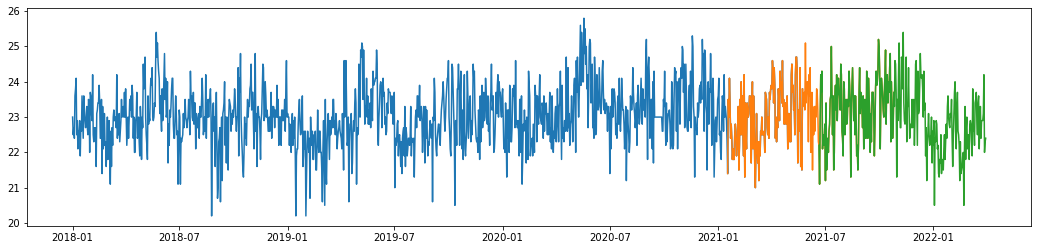

In [7]:
plt.figure(figsize=(18,4))
plt.plot(dtrain)
plt.plot(dval)
plt.plot(dtest)

# Standarization for data train

In [8]:
dev_val = dtrain.std()[0]
mean_val = dtrain.mean()[0]

def make_std(data):
    data_std = data    
    data_std = (data_std-mean_val)/dev_val
    
    return data_std

In [9]:
dtrain_std = make_std(dtrain)

In [10]:
dval_std = make_std(dval)

In [11]:
dtest_std = make_std(dtest)

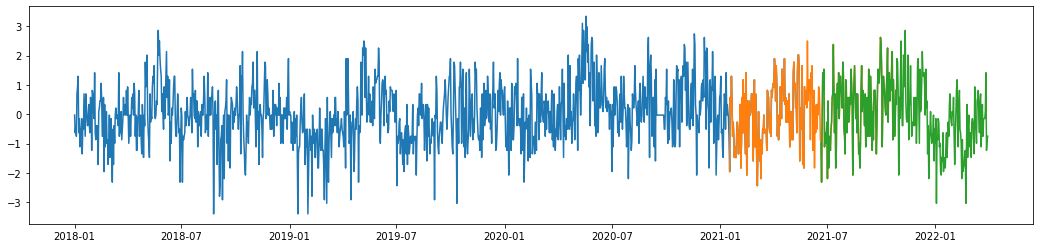

In [12]:
plt.figure(figsize=(18,4))
plt.plot(dtrain_std)
plt.plot(dval_std)
plt.plot(dtest_std)

# De-standarization Function

In [13]:
def de_std(df):
    column = ['Predictions', 'Actuals']
    for index, row in df.iterrows():
        for col in column:
            val = df.loc[index, col]
            df.loc[index, col] = (dev_val * val) + mean_val        

# Executing Forecast

In [ ]:
def execute_forecast(pred, actual, date):
    df_result = pd.DataFrame(data={'date': date, 'Predictions': pred, 'Actuals': actual})
    df_result.set_index('date', inplace=True)
    
    de_std(df_result)
    
    plt.figure(figsize=(18,8))
    plt.plot(df_result['Actuals'], 'r--')
    plt.plot(df_result['Predictions'], 'b')

    plt.show()
    
    MAE = mean_absolute_error(df_result['Actuals'], df_result['Predictions'])
    RMSE = sqrt(mean_squared_error(df_result['Actuals'], df_result['Predictions']))

    print(f'Mean Absolute Error is\t\t: {MAE}')
    print(f'Root Mean Squared Error is\t: {RMSE}')
    
    return df_result, MAE, RMSE

## Get x and y values

In [14]:
X_train, y_train, date_train = df_to_array(dtrain_std, WINDOW_SIZE)
X_val, y_val, date_val = df_to_array(dval_std, WINDOW_SIZE)
X_test, y_test, date_test = df_to_array(dtest_std, WINDOW_SIZE)

# Creating the Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [ ]:
model_loc = 'LSTM_models/'+ATTR_CODE+'_n'+str(NEURON_LAYER)+'_e'+str(EPOCH)+'/'

# Create and saving the Model

In [ ]:
model = Sequential()
model.add(InputLayer((WINDOW_SIZE,1)))
model.add(LSTM(NEURON_LAYER))
model.add(Dense(64, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

In [ ]:
cp = ModelCheckpoint(model_loc, save_best_only=True)

In [ ]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
%%time
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCH, callbacks=[cp])

# Load the Model

In [ ]:
model1 = load_model(model_loc)

In [ ]:
model1.summary()

## Train Results

In [ ]:
train_res = model1.predict(X_train).flatten()

In [ ]:
train_df, train_MAE, train_RMSE = execute_forecast(train_res, y_train, date_train)

## Validation Results

In [ ]:
val_res = model1.predict(X_val).flatten()

In [ ]:
val_df, val_MAE, val_RMSE = execute_forecast(val_res, y_val, date_val)

# Updating data validation to model

In [ ]:
model_val_loc = model_loc[:-1] + '_val/'

In [ ]:
u_cp = ModelCheckpoint(model_val_loc, save_best_only=True)

In [ ]:
%%time
model1.fit(X_val, y_val, validation_data=(X_test, y_test), epochs=EPOCH, callbacks=[u_cp])

## Test Results

In [ ]:
model2 = load_model(model_val_loc)

In [ ]:
test_res = model2.predict(X_test).flatten()

In [ ]:
test_df, test_MAE, test_RMSE = execute_forecast(test_res, y_test, date_test)

# k-period forecast

In [ ]:
def one_step_forecast(model, X):
    X_val = np.array(X)
    result = model.predict(X_val).flatten()
    X_val_update = []
    
    for lags in X_val:
        lags_update = []
        
        for value in lags:
            lags_update.append(value)
        
        lags_update.append(result)
        lags_update = lags_update[1:]
        
        X_val_update.append(lags_update)
    
    return result, np.array(X_val_update)

In [ ]:
def LSTM_forecast(model, period, x_input):
    x_input = [x_input]
    final_result = []
    iteration = 0
    while iteration < period:
        result, x_input = one_step_forecast(model, x_input)
        final_result.append(result[0])
        iteration += 1
    return np.array(final_result), x_input

In [ ]:
def get_period_forecast(model, X, period, date, y_act=[]):
    res = []
    pred_date = []
    for i in np.arange(0, len(X), period):
        X_start = X[i]
        result, __ = LSTM_forecast(model, period=period, x_input=X_start)
        
        ## updating model
        if len(y_act) > 0:
            for prd in range(0,period):
                if (i+prd) < len(X):
                    X_up = np.reshape(X[i+prd], (1, X.shape[1], X.shape[2]))
                    y_up = np.reshape(y_act[i+prd], (1,))
                    print(f"({i+prd}/{len(X)-1}) updating {date[i+prd]} into model")
                    model.fit(X_up, y_up, epochs=1)
                    
        res.append(result)
        pred_date.append(date[i])
    return np.array(res), np.array(pred_date)

In [ ]:
def collect_k_res(k_res, length):
    res_val = []
    counter = 0
    for pred in k_res:
        for val in pred:
            if counter < length:
                res_val.append(val)
            counter += 1
    return np.array(res_val)

In [ ]:
def period_forecast(model, period, X, y, date):
    k_res, k_date = get_period_forecast(model, X, period, date, y_act=y)
    k_res_val = collect_k_res(k_res, len(X))
    return k_res_val

In [ ]:
def forcast_scene(model_loc, period, X, y, date):
    sc_model = load_model(model_loc)
    sc_frc = period_forecast(sc_model, period=period, X=X, y=y, date=date)
    sc_df, sc_MAE, sc_RMSE = execute_forecast(sc_frc, y_test, date_test)
    return sc_df, sc_MAE, sc_RMSE

# Forecasting scenario

In [ ]:
sc1_df, sc1_MAE, sc1_RMSE = forcast_scene(model_val_loc, period=1, X=X_test, y=y_test, date=date_test)

In [ ]:
sc2_df, sc2_MAE, sc2_RMSE = forcast_scene(model_val_loc, period=3, X=X_test, y=y_test, date=date_test)

In [ ]:
sc3_df, sc3_MAE, sc3_RMSE = forcast_scene(model_val_loc, period=7, X=X_test, y=y_test, date=date_test)

# Collecting All Predictions Scenario Result

In [ ]:
def plot_forecasts_result(df):
    title = 'Peramalan ' + ATTR_NAME + ' LSTM'
    
    plt.figure(figsize=(18,8))
    plt.title(title)
    plt.plot(df['scn-1'], 'r-', label='1-step forecast')
    plt.plot(df['scn-2'], 'b-', label='3-step forecast')
    plt.plot(df['scn-3'], 'g-', label='7-step forecast')
    plt.plot(df['Actuals'], color='black', linestyle=':' , label='Actuals')
    plt.legend()

In [ ]:
def col_forcasts_err(res_df):
    for col in [x for x in range(len(forecasts_result.columns)-1)]:
        col_name = res_df.columns[col]
        MAE = mean_absolute_error(res_df['Actuals'], res_df[col_name])
        RMSE = sqrt(mean_squared_error(res_df['Actuals'], res_df[col_name]))
        print('Error for ', col_name)
        print(f'Mean Absolute Error is\t\t: {MAE}')
        print(f'Root Mean Squared Error is\t: {RMSE}')
        print()

In [ ]:
sc1_df_cp = sc1_df.copy()
sc1_df_cp.columns = ['scn-1', 'Actuals']

sc2_df_cp = sc2_df.copy()
sc2_df_cp.columns = ['scn-2', 'Actuals']

sc3_df_cp = sc3_df.copy()
sc3_df_cp.columns = ['scn-3', 'Actuals']

In [ ]:
forecasts_result = pd.concat([sc1_df_cp[[sc1_df_cp.columns[0]]],
                              sc2_df_cp[[sc2_df_cp.columns[0]]],
                              sc3_df_cp[[sc3_df_cp.columns[0]]],
                              sc1_df_cp[[sc3_df_cp.columns[1]]]
                             ],
                               axis='columns')

In [ ]:
plot_forecasts_result(forecasts_result)

In [ ]:
col_forcasts_err(forecasts_result)

## Saving forecasts result

In [ ]:
forecasts_result.to_csv('LSTM_results_temp/'+ATTR_CODE+'_n'+str(NEURON_LAYER)+'_e'+str(EPOCH)+'.csv')

# Calling Forecasting Result

In [ ]:
FILE_NEURON = NEURON_LAYER
FILE_EPOCH = EPOCH

In [ ]:
df_call = pd.read_csv('LSTM_results_temp/'+ATTR_CODE+'_n'+str(FILE_NEURON)+'_e'+str(FILE_EPOCH)+'.csv')
df_call.date = pd.to_datetime(df_call.date, format='%Y-%m-%d')
df_call.set_index('date', inplace=True)
df_call.head()

In [ ]:
plot_forecasts_result(df_call)

In [ ]:
col_forcasts_err(df_call)